In [1]:
"""
Inspired by this blog

https://iwatobipen.wordpress.com/2018/11/27/visualize-pharmacophore-in-rdkit-rdkit/
"""

from nanome.service import PluginService
from nanome.interface import PluginInstanceRedisInterface

# Set up redis credentials
redis_host = 'redis'
redis_port = 6379
redis_password = ''

# When your PluginService is running, you can get your channel value from the Logs, or from the query parameter in your open browser.
# Update this value to match that, so that your commands will run against your live workspace.
redis_channel = 'a5100bcd-3b33-48dc-a8b0-67f88182f24e'

plugin_instance = PluginInstanceRedisInterface(redis_host, redis_port, redis_password, redis_channel)
print('Hello')

Creating config file with path /root/.nanome_lib/config.txt
Hello


In [6]:
# Test connection to Session
comps = plugin_instance.request_complex_list()
print(comps)
comp = comps[0]
comp = plugin_instance.request_complexes([comp.index])[0]

Sending request_complex_list Request to Redis Channel a5100bcd-3b33-48dc-a8b0-67f88182f24e
Response received on channel 0834adf0-b65f-4cce-89cd-457815a8a762
Sending request_complexes Request to Redis Channel a5100bcd-3b33-48dc-a8b0-67f88182f24e
Response received on channel 17263588-1738-400b-aa51-da87229bbc53


In [7]:
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import rdBase
from rdkit.RDPaths import RDDocsDir
from rdkit.RDPaths import RDDataDir
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import os
print(rdBase.rdkitVersion)
IPythonConsole.ipython_useSVG=True

2020.09.5


In [8]:
fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFact = ChemicalFeatures.BuildFeatureFactory(fdefFile)

In [9]:
from nanome.api.structure import Complex
import tempfile

temp_file = tempfile.NamedTemporaryFile(suffix='.sdf')
with open(temp_file.name, 'w') as f:
    comp.io.to_sdf(path=temp_file.name)

mols = [m for m in Chem.SDMolSupplier(temp_file.name)]
featslists = [featFact.GetFeaturesForMol(mol) for mol in mols]
for mol in mols:
    m3 = Chem.AddHs(mol)
    AllChem.EmbedMolecule(m3, randomSeed=0xf00d)

In [10]:
def drawp4core(mol, feats):
    atoms_list = {}
    for feat in feats:
        atom_ids = feat.GetAtomIds()
        feat_type = feat.GetType()
        atoms_list[feat_type] = atom_ids
    return Draw.MolsToGridImage(
        [mol]*len(atoms_list),
        legends=list(atoms_list.keys()),
        highlightAtomLists=list(atoms_list.values()))

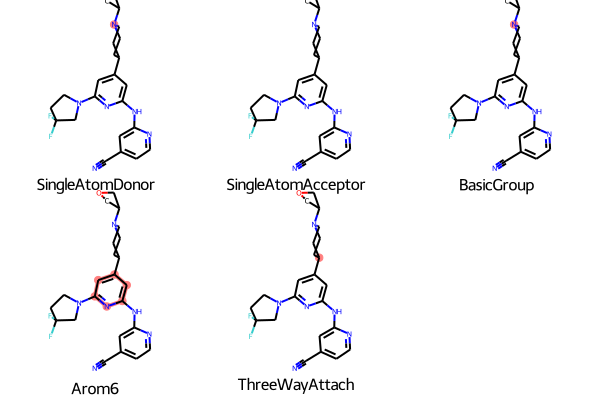

In [11]:
# from IPython.core.debugger import Pdb; Pdb().set_trace()
im = drawp4core(mols[0], featslists[0])
im

In [12]:
import nanome
from nanome.api.shapes import Anchor, Sphere
from nanome.util import Color, Vector3
"""
Visualize aromatic features.

Pharmacophore features are color-coded 
cyan, hydrophobic;
orange, ring aromatic;
green, hydrogen bond acceptor
"""

ORANGE = Color(255, 165, 0, 75)
CYAN = Color(0, 255, 255, 75)
GREEN = Color(0, 255, 0, 75)

def centroid(atom_list):
    """Calculate center of a collection of atoms (Usually an aromatic ring)."""
    coords = [a.position.unpack() for a in atom_list]
    sum_x = sum([vec[0] for vec in coords])
    sum_y = sum([vec[1] for vec in coords])
    sum_z = sum([vec[2] for vec in coords])
    len_coord = len(coords)
    centroid = Vector3(sum_x / len_coord, sum_y / len_coord, sum_z / len_coord)
    return centroid

def calculate_local_offset(anchor, atom_list):
    """Calculate offset to move line anchor to center of ring."""
    ring_center = centroid(atom_list)
    anchor_atom = next(iter(atom for atom in atom_list if atom.index == anchor.target))
    anchor_position = anchor_atom.position
    offset_vector = Vector3(
        ring_center.x - anchor_position.x,
        ring_center.y - anchor_position.y,
        ring_center.z - anchor_position.z
    )
    return offset_vector

def render_feature(feature, comp, color):
    atom_idxs = feature.GetAtomIds()
    sphere = Sphere()
    sphere.color = color

    aromatic_atoms = []
    for i, atom in enumerate(comp.atoms):
        if i in atom_idxs:
            aromatic_atoms.append(atom)

    atom = aromatic_atoms[0]
    anchor = sphere.anchors[0]
    anchor.anchor_type = nanome.util.enums.ShapeAnchorType.Atom
    anchor.target = atom.index
    anchor.local_offset = calculate_local_offset(anchor, aromatic_atoms)
    sphere.anchors.append(anchor)
    sphere.radius = 2
    return sphere

feature_list = featslists[0]

aromatic_feature_names = [f'Arom{str(x)}' for x in range(4, 9)]
hydrophobic_feature_names = [
    'ThreeWayAttach', 'ChainTwoWayAttach', 'Nitro2', 'RH4_4', 'RH5_5',
    'RH6_6', 'tButyl', 'iPropyl'
]
donor_feature_names = ['SingleAtomDonor']
acceptor_feature_names = ['SingleAtomAcceptor']
negionizable_feature_names = ['AcidicGroup']
posionizable_feature_names = ['BasicGroup', 'PosN', 'Imidazole', 'Guanidine']
znbinder_feature_names = [f'ZnBinder{str(x)}' for x in range(1, 7)]

shapes = []
for feat in feature_list:
    feat_type = feat.GetType()
    color = Color.Gray()
    
    sphere = None    
    if feat_type in aromatic_feature_names:
        color = ORANGE
        sphere = render_feature(feat, comp, color)
    if feat_type in hydrophobic_feature_names:
        color = CYAN
        sphere = render_feature(feat, comp, color)
    if feat_type in acceptor_feature_names:
        color = GREEN
        sphere = render_feature(feat, comp, color)

    if sphere:
        shapes.append(sphere)
plugin_instance.upload_shapes(shapes)



Sending upload_shapes Request to Redis Channel a5100bcd-3b33-48dc-a8b0-67f88182f24e
Response received on channel da825a59-5308-4c73-a86a-7d8a1d3ee7eb
